<a href="https://colab.research.google.com/github/raktim711/AIMS-project---Anomaly-Detection/blob/main/Downsampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downsampling of the dataset

In this notebook, after loading the data, effective sample size is calculated. The downsampling of the dataset is done before being quickly tested on a Random Forest classifer. The downsampling method has also been described.

In [1]:
import numpy as np
import h5py
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import umap.umap_ as umap

In [2]:
# Set plotting style at module level
plt.rcParams.update({
    # Font sizes
    'font.size': 18,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'legend.frameon': False,  # No box around legend
    'axes.grid': False,
    # Tick settings
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 10,
    'ytick.major.size': 10,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5,
    'xtick.major.width': 1,
    'ytick.major.width': 1,
    'xtick.top': True,
    'ytick.right': True,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True
})

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the Data

In [4]:
def combine_data(datasets, tags_to_combine, new_tag, delete_old_tags=True):
    """
    Combines subdicts of the 'datasets' dict.

    Inputs:
        datasets: dict that maps {dataset_tag : dataset_dict}
        tags_to_combine: list if strings [dataset_tag1, ..., dataset_tagN] of the tags to be combined
        new_tag: the name of the new tag of the combined subdict

    Returns:
        datasets: same datasets dict as input, but with the specified tags combined.
    """

    # initialize empty lists for new tag
    datasets[new_tag] = {key: [] for key in datasets[tags_to_combine[0]].keys()}

    # Loop through old tags and append np arrays to lists
    for tag in tags_to_combine:
        for key, value in datasets[tag].items():
            datasets[new_tag][key].append(value)

    # Concatenate lists into single np array
    for key, value in datasets[new_tag].items():
        datasets[new_tag][key] = np.concatenate(value, axis=0)

    # Delete old tags
    if delete_old_tags:
        for tag in tags_to_combine:
            del datasets[tag]

    # Make sure everything is an np array
    for tag, data_dict in datasets.items():
        for key, value in data_dict.items():
            data_dict[key] = np.array(value)

    return datasets

In [5]:
# Load the data

datasets = {} # dictionary of dictionaries, each dictionary is a dataset

# base_dir = '/kaggle/input/addata/ADdata'
base_dir = '/content/drive/MyDrive/Datasets/ADdata'

# loop over all the files in the base directory
for tag in os.listdir(base_dir):
    file_path = os.path.join(base_dir, tag)

    datasets[tag] = {}

    # load the data from the file
    with h5py.File(file_path, 'r') as hf:
        for key in hf.keys():
            datasets[tag][key] = hf[key][:]

# Print the shape of the data
for tag, data_dict in datasets.items():
    print(f'{tag}:')
    for key, value in data_dict.items():
        print(f'  {key}: {value.shape}')

EB25_500306.h5:
  HLTAD_scores: (1017586,)
  HLT_data: (1017586, 48)
  HLT_el_IDs: (1017586, 3)
  HLT_jet_E: (1017586, 6)
  HLT_z: (1017586, 4)
  L1AD_scores: (1017586,)
  L1_data: (1017586, 44)
  LBs: (1017586,)
  avg_ints: (1017586,)
  bcid: (1017586,)
  event_numbers: (1017586,)
  mus: (1017586,)
  online_AD_scores: (1017586,)
  passHLTAD_online: (1017586,)
  passL1ADL_online: (1017586,)
  passL1ADT_online: (1017586,)
  pass_HLTAD: (1017586,)
  pass_HLT_unprescaled: (1017586,)
  pass_L1AD: (1017586,)
  pass_L1_unprescaled: (1017586,)
  pass_single_jet_trigger: (1017586,)
  run_numbers: (1017586,)
  weights: (1017586,)
MC_HAHMggf_470000.h5:
  HLTAD_scores: (100000,)
  HLT_data: (100000, 48)
  HLT_el_IDs: (100000, 3)
  HLT_jet_E: (100000, 6)
  HLT_z: (100000, 4)
  L1AD_scores: (100000,)
  L1_data: (100000, 44)
  LBs: (100000,)
  avg_ints: (100000,)
  bcid: (100000,)
  event_numbers: (100000,)
  mus: (100000,)
  online_AD_scores: (100000,)
  passHLTAD_online: (100000,)
  passL1ADL_onli

In [6]:
# Remove EB24 data
for tag in [key for key in datasets.keys()]:
    if tag.startswith('EB24'):
        del datasets[tag]

# Rename EB25 to EB_test
datasets['EB_test'] = datasets.pop('EB25_500306.h5')

In [7]:
# Change pass_HLT_unprescaled to boolean and add weights for MC
for tag, data_dict in datasets.items():
    data_dict['passHLT'] = data_dict['pass_HLT_unprescaled']==1
    del data_dict['pass_HLT_unprescaled']

    data_dict['passL1'] = data_dict['pass_L1_unprescaled']==1
    del data_dict['pass_L1_unprescaled']

    if tag.startswith('MC'):
        data_dict['weights'] = np.ones(len(data_dict['run_numbers']))

Except for ```EB_test```, all the other classes have been weighted 1.0



In [8]:
# Rename the MC tags for clarity

original_tags = [tag for tag in datasets.keys()]

for tag in original_tags:
    if tag.startswith('MC'):
        new_tag = tag.split('MC_')[1]
        new_tag = new_tag.split('_470000')[0]

        if new_tag == 'hh':
            new_tag = 'hh_bbbb_vbf_novhh_5fs_l1cvv1cv1'

        datasets[new_tag] = datasets.pop(tag)

for tag, data_dict in datasets.items():
    print(f'{tag}:')
    for key, value in data_dict.items():
        print(f'  {key}: {value.shape}')

EB_test:
  HLTAD_scores: (1017586,)
  HLT_data: (1017586, 48)
  HLT_el_IDs: (1017586, 3)
  HLT_jet_E: (1017586, 6)
  HLT_z: (1017586, 4)
  L1AD_scores: (1017586,)
  L1_data: (1017586, 44)
  LBs: (1017586,)
  avg_ints: (1017586,)
  bcid: (1017586,)
  event_numbers: (1017586,)
  mus: (1017586,)
  online_AD_scores: (1017586,)
  passHLTAD_online: (1017586,)
  passL1ADL_online: (1017586,)
  passL1ADT_online: (1017586,)
  pass_HLTAD: (1017586,)
  pass_L1AD: (1017586,)
  pass_single_jet_trigger: (1017586,)
  run_numbers: (1017586,)
  weights: (1017586,)
  passHLT: (1017586,)
  passL1: (1017586,)
HAHMggf:
  HLTAD_scores: (100000,)
  HLT_data: (100000, 48)
  HLT_el_IDs: (100000, 3)
  HLT_jet_E: (100000, 6)
  HLT_z: (100000, 4)
  L1AD_scores: (100000,)
  L1_data: (100000, 44)
  LBs: (100000,)
  avg_ints: (100000,)
  bcid: (100000,)
  event_numbers: (100000,)
  mus: (100000,)
  online_AD_scores: (100000,)
  passHLTAD_online: (100000,)
  passL1ADL_online: (100000,)
  passL1ADT_online: (100000,)
  

In [9]:
HLT_data_tags = [tag for tag in datasets.keys() if not tag.startswith('MC')]

In [10]:
print(HLT_data_tags)

['EB_test', 'HAHMggf', 'HNLeemu', 'HtoSUEP', 'VBF_H125_a55a55_4b_ctau1_filtered', 'Znunu', 'ggF_H125_a16a16_4b_ctau10_filtered', 'hh_bbbb_vbf_novhh_5fs_l1cvv1cv1']


In [11]:
# Define column names for HLT_data
columns = ['j0pt', 'j0eta', 'j0phi', 'j1pt', 'j1eta', 'j1phi',
           'j2pt', 'j2eta', 'j2phi', 'j3pt', 'j3eta', 'j3phi',
           'j4pt', 'j4eta', 'j4phi', 'j5pt', 'j5eta', 'j5phi',
           'e0pt', 'e0eta', 'e0phi', 'e1pt', 'e1eta', 'e1phi',
           'e2pt', 'e2eta', 'e2phi', 'mu0pt', 'mu0eta', 'mu0phi',
           'mu1pt', 'mu1eta', 'mu1phi', 'mu2pt', 'mu2eta', 'mu2phi',
           'ph0pt', 'ph0eta', 'ph0phi', 'ph1pt', 'ph1eta', 'ph1phi',
           'ph2pt', 'ph2eta', 'ph2phi', 'METpt', 'METeta', 'METphi']

In [12]:
combined_hlt_df = pd.concat([
    pd.DataFrame(datasets[tag]['HLT_data'], columns=columns)
      .assign(weight=np.asarray(datasets[tag]['weights']).reshape(-1), target=tag)
    for tag in datasets
], ignore_index=True)
combined_hlt_df.head()

,j0pt,j0eta,j0phi,j1pt,j1eta,j1phi,j2pt,j2eta,j2phi,j3pt,...,ph1eta,ph1phi,ph2pt,ph2eta,ph2phi,METpt,METeta,METphi,weight,target
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.009135,0.0,-1.915390,5.0,EB_test
1,23.893738,-0.032734,1.230678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.742011,0.0,-1.910914,5.0,EB_test
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,12.0,EB_test
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.936713,0.0,-0.541381,12.0,EB_test
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,5.0,EB_test


## Exploratory Data Visualisation

In [13]:
# Define the target name you want to filter by
target_name = 'EB_test'
filtered_df = combined_hlt_df[combined_hlt_df['target'] == target_name].drop(['target', 'weight'], axis=1)

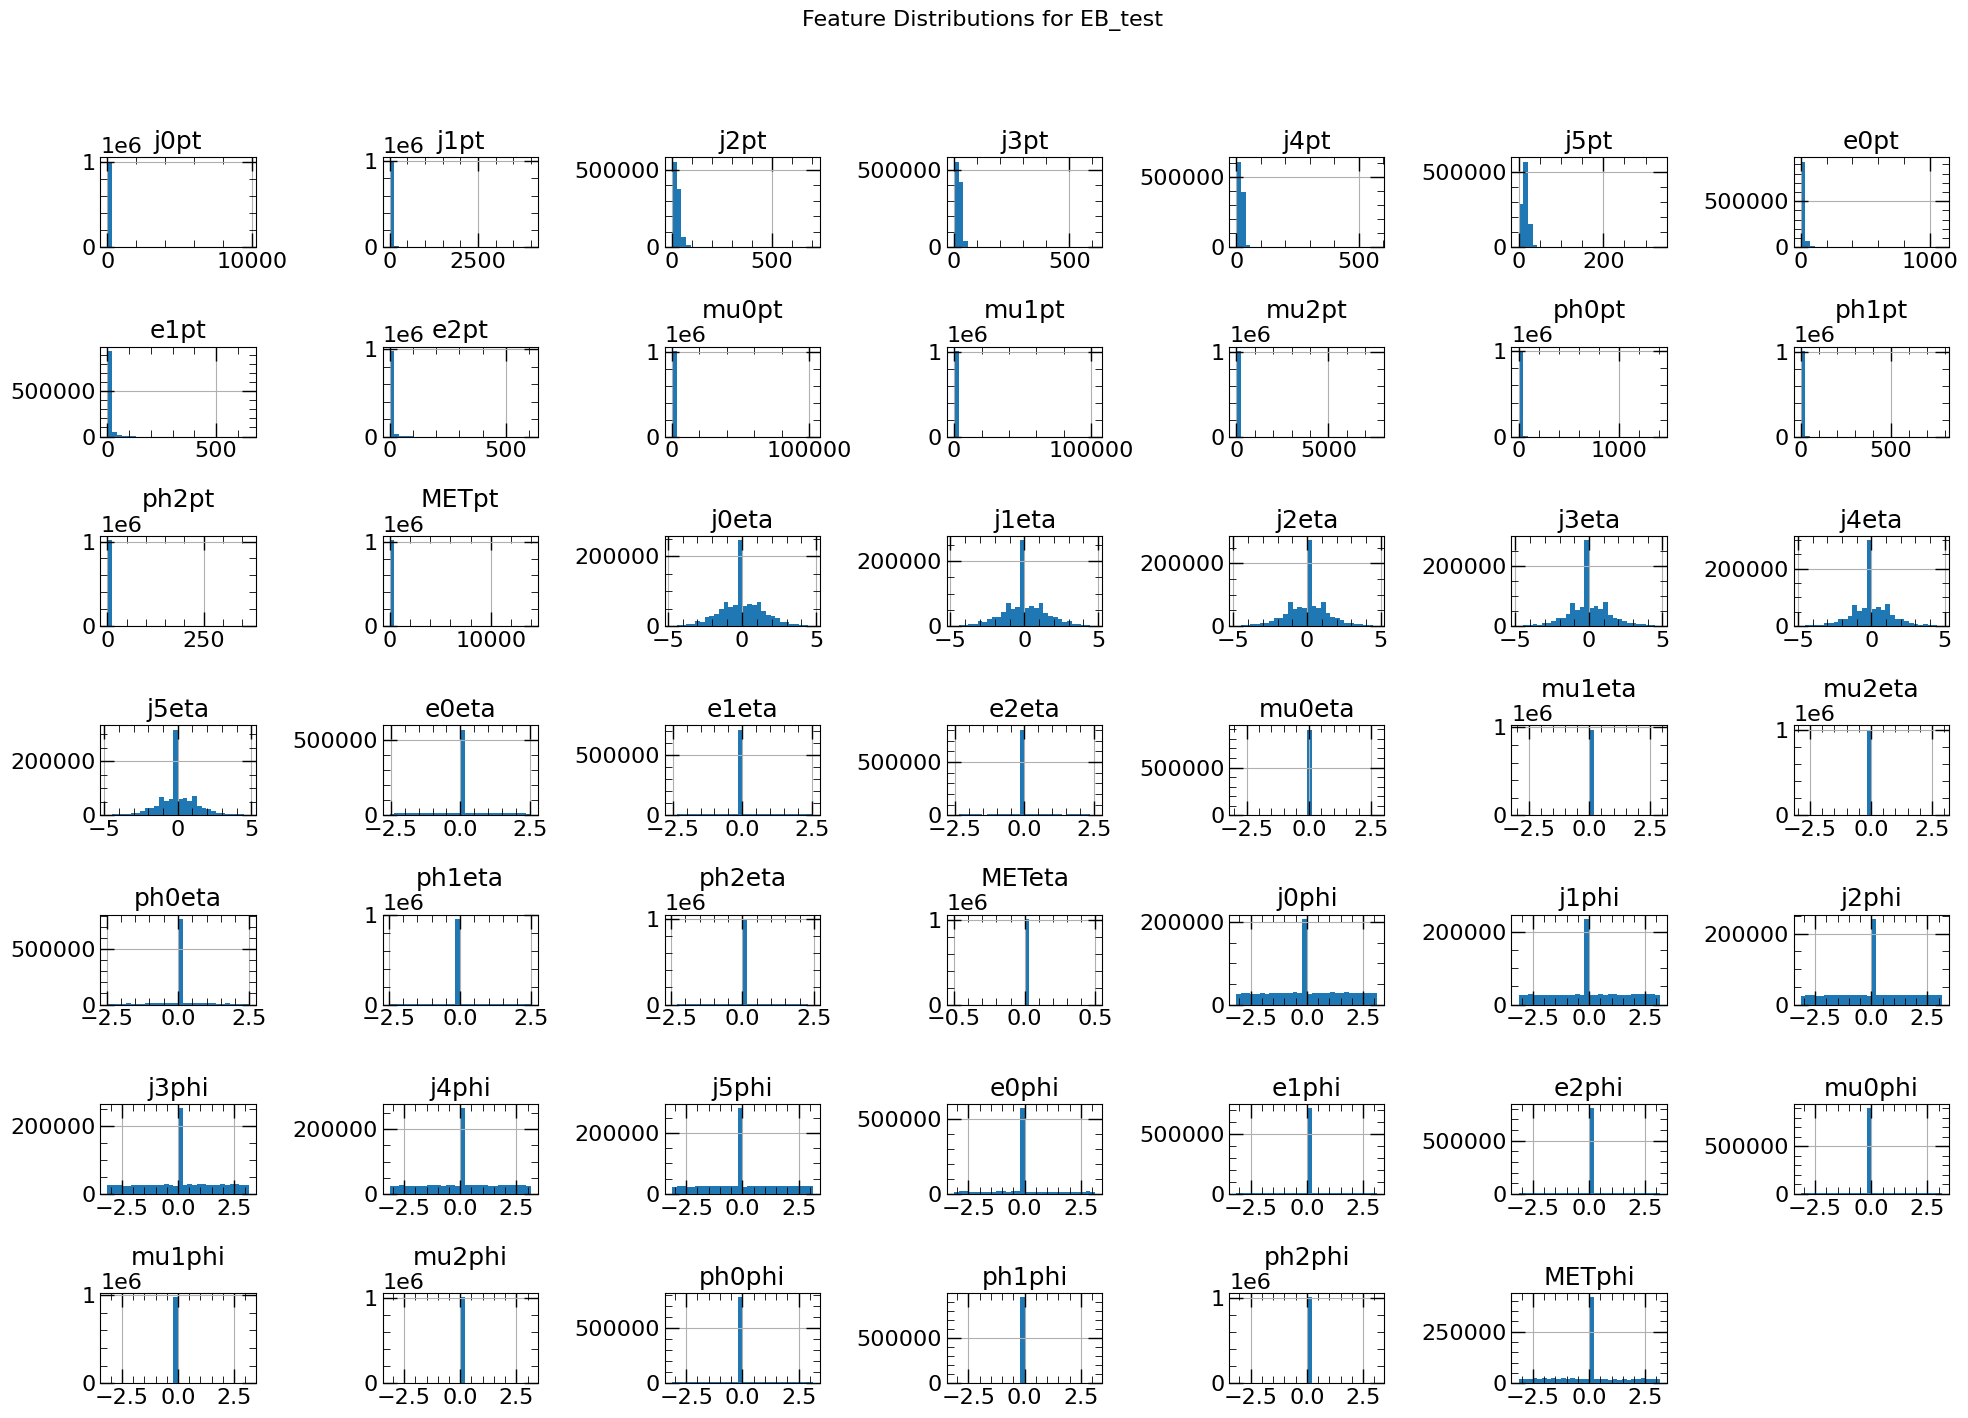

In [14]:
# Plot histograms directly from the filtered and dropped DataFrame
# Quick and Simple plot
# combined_hlt_df[combined_hlt_df['target'] == target_name].drop('target', axis=1).hist(figsize=(20,15), bins=30)

# plt.suptitle(f'Feature Distributions for {target_name}')
# plt.tight_layout()
# plt.show()


# Filter data for the selected target
df_target = filtered_df

# Define feature groups based on name patterns
pt_cols = [c for c in df_target.columns if 'pt' in c]
eta_cols = [c for c in df_target.columns if 'eta' in c]
phi_cols = [c for c in df_target.columns if 'phi' in c]
# met_cols = [c for c in df_target.columns if 'MET' in c]
other_cols = ['weight'] if 'weight' in df_target.columns else []

# Combine in desired order
ordered_cols = pt_cols + eta_cols + phi_cols + other_cols

# Plot histograms grouped by type
df_target[ordered_cols].hist(
    figsize=(20, 15),
    bins=30,
)

plt.suptitle(f'Feature Distributions for {target_name}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Effective Sample size of the dataset

### What this code does:

- Computes **Kish ESS** for each class:

  $$
  n_{\text{eff}} = \frac{(\sum_i w_i)^2}{\sum_i w_i^2}
  $$

- Prints a clear **summary table** with counts, sums, and ESS.



Overall Effective Sample Size (ESS): 261,871
Raw event count: 1,487,586
Sum of weights: 112,198,863,150.86
Sum of weights²: 48,071,693,563,705,984.00

                                          count              sum_w  \
target                                                               
EB_test                            1,017,586.00 112,198,393,150.86   
HAHMggf                              100,000.00         100,000.00   
HNLeemu                              100,000.00         100,000.00   
HtoSUEP                              100,000.00         100,000.00   
VBF_H125_a55a55_4b_ctau1_filtered    100,000.00         100,000.00   
hh_bbbb_vbf_novhh_5fs_l1cvv1cv1       50,000.00          50,000.00   
Znunu                                 10,000.00          10,000.00   
ggF_H125_a16a16_4b_ctau10_filtered    10,000.00          10,000.00   

                                                      sum_w2        ESS  \
target                                                                  

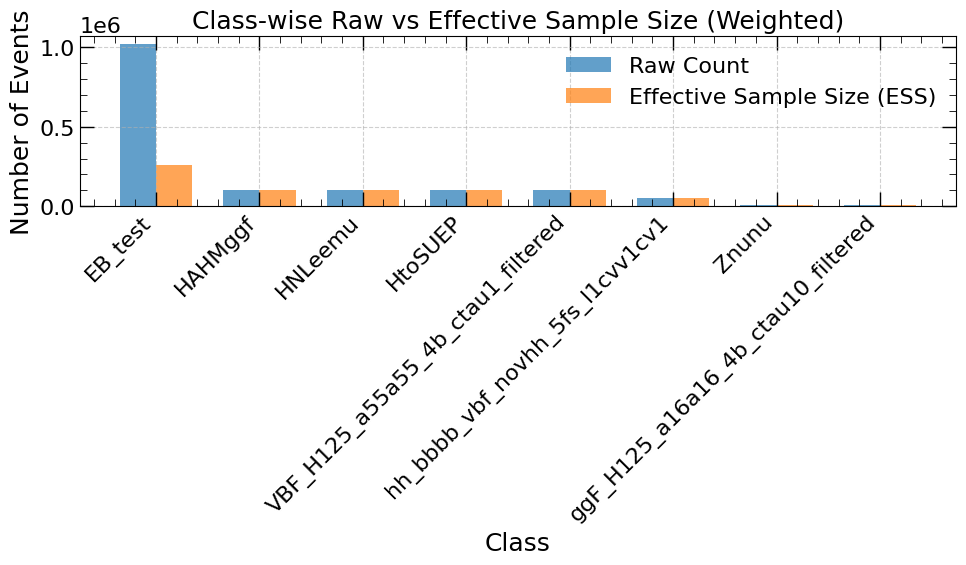

In [15]:
# ---------------------------------------------------------
# Function: Kish Effective Sample Size
# ---------------------------------------------------------
def effective_sample_size_from_weights(w):
    """Compute effective sample size (ESS) using Kish's formula."""
    w = np.asarray(w, dtype=float)
    w = w[np.isfinite(w)]  # remove NaN / inf
    sum_w = np.sum(w)
    sum_w2 = np.sum(w**2)
    return (sum_w ** 2) / sum_w2 if sum_w2 > 0 else 0.0


# ---------------------------------------------------------
# Overall Effective Sample Size
# ---------------------------------------------------------
weights = combined_hlt_df['weight']
sum_w = weights.sum()
sum_w2 = np.sum(weights**2)
n_eff_overall = (sum_w ** 2) / sum_w2 if sum_w2 > 0 else 0.0

print(f"\nOverall Effective Sample Size (ESS): {n_eff_overall:,.0f}")
print(f"Raw event count: {len(weights):,}")
print(f"Sum of weights: {sum_w:,.2f}")
print(f"Sum of weights²: {sum_w2:,.2f}\n")


# ---------------------------------------------------------
# Per-Class Effective Sample Size
# ---------------------------------------------------------
per_class_stats = (
    combined_hlt_df
    .groupby('target', group_keys=False, observed=True)   # safer grouping
    .apply(lambda g: pd.Series({
        'count': len(g),
        'sum_w': g['weight'].sum(),
        'sum_w2': (g['weight']**2).sum(),
        'ESS': effective_sample_size_from_weights(g['weight'])
    }), include_groups=False)
    .sort_values('ESS', ascending=False)
)

# Add a normalized ESS metric (ESS / raw count)
per_class_stats['ESS_per_count'] = per_class_stats['ESS'] / per_class_stats['count']

# Display neatly
pd.set_option('display.float_format', '{:,.2f}'.format)
print(per_class_stats)

# ---------------------------------------------------------
# Plot: Raw count vs Effective Sample Size
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(per_class_stats))
width = 0.35  # bar width

ax.bar(x - width/2, per_class_stats['count'], width, label='Raw Count', alpha=0.7)
ax.bar(x + width/2, per_class_stats['ESS'], width, label='Effective Sample Size (ESS)', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(per_class_stats.index, rotation=45, ha='right')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Events')
ax.set_title('Class-wise Raw vs Effective Sample Size (Weighted)')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Optional: save stats
# ---------------------------------------------------------
# per_class_stats.to_csv("effective_sample_sizes.csv")


## Model Training



```
My data is in a pandas dataframe, combined_hlt_df. 48 features and 1 target variable called 'target' and 1 column 'weight' containing weights for the respective events (rows).
target
EB_test                               1017586
HAHMggf                                100000
HNLeemu                                100000
HtoSUEP                                100000
VBF_H125_a55a55_4b_ctau1_filtered      100000
hh_bbbb_vbf_novhh_5fs_l1cvv1cv1         50000
Znunu                                   10000
ggF_H125_a16a16_4b_ctau10_filtered      10000
Name: count, dtype: int64
Make all the targets except for EB_test my signals. Do train-test split.
Make a binary classification model. Also give the model evaluation code and hyperparameter tuning.
```



## Downsampling the Dataset
We are creating a dataset with all the signals combined and equal amount of signal and background.

### How do we do it?

We use `DataFrame.sample(n=None, frac=None, replace=False, weights=None, random_state=None, axis=None, ignore_index=False)`.

Here we use the `weights` parameter to sample proportionally to the weights.

#### Code Summary — Weighted Downsampling and Train/Test Split

- **Creates a binary target (`y`)**:
  - `1` → all signal events (anything **not** labeled `'EB_test'`)
  - `0` → background events (`'EB_test'`)

- **Defines feature matrix (`X`)**:
  - Uses all columns from `combined_hlt_df` **except** `'target'` and `'weight'`.

- **Separates data into majority (background) and minority (signal) classes**:
  - `X_major`, `y_major` → background (`EB_test`)
  - `X_minor`, `y_minor` → signal (all others)

- **Extracts event weights** for the majority class (`w_major`).

- **Performs weighted downsampling** of the background:
  - Samples a subset of `EB_test` events with probability **proportional to their weight**.
  - Sample size = number of signal events (creates balanced classes).
  - Sampling is **without replacement** to avoid duplicates.

- **Combines**:
  - Downsampled majority class (`X_major_downsampled`)  
  - Entire minority class (`X_minor`)
  - → into a **balanced dataset** (`X_balanced`, `y_balanced`).

- **Shuffles** the balanced data randomly to mix signal and background events.

- **Splits** the balanced dataset into **train** (80%) and **test** (20%) sets:
  - Uses `stratify=y_balanced` to preserve class balance in both splits.
  - Sets `random_state=42` for reproducibility.





In [16]:
# --- Setup ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report

# ==== 1) Make binary target: signal=1 for everything except EB_test ====
y = (combined_hlt_df['target'] != 'EB_test').astype(int)

# Features: all columns except 'target' and 'weight'
feature_cols = [c for c in combined_hlt_df.columns if c not in ('target', 'weight')]
X = combined_hlt_df[feature_cols]

# ==== 2) Balance the classes by weighted downsampling of the majority class ====

# Separate majority (background) and minority (signal)
X_major = X[y == 0].copy()
y_major = y[y == 0].copy()

X_minor = X[y == 1].copy()
y_minor = y[y == 1].copy()

# Extract corresponding weights for the majority class
w_major = combined_hlt_df.loc[y == 0, 'weight']

# Number of samples to draw = number of minority samples
n_minority = len(X_minor)

# Weighted downsampling (probability ∝ weight)
X_major_downsampled = X_major.sample(
    n=n_minority,
    replace=False,
    weights=w_major,      # <-----sampling proportional to the weights
    random_state=42
)

# Match y accordingly
y_major_downsampled = y_major.loc[X_major_downsampled.index]

# Combine minority class with downsampled majority class
X_balanced = pd.concat([X_major_downsampled, X_minor])
y_balanced = pd.concat([y_major_downsampled, y_minor])

# Shuffle the balanced dataset
from sklearn.utils import shuffle
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)



# ==== 3) Train/Test split (stratified) on balanced data ====
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)


Checking if the above code does what it should

**Weighted vs. Downsampled Histograms**

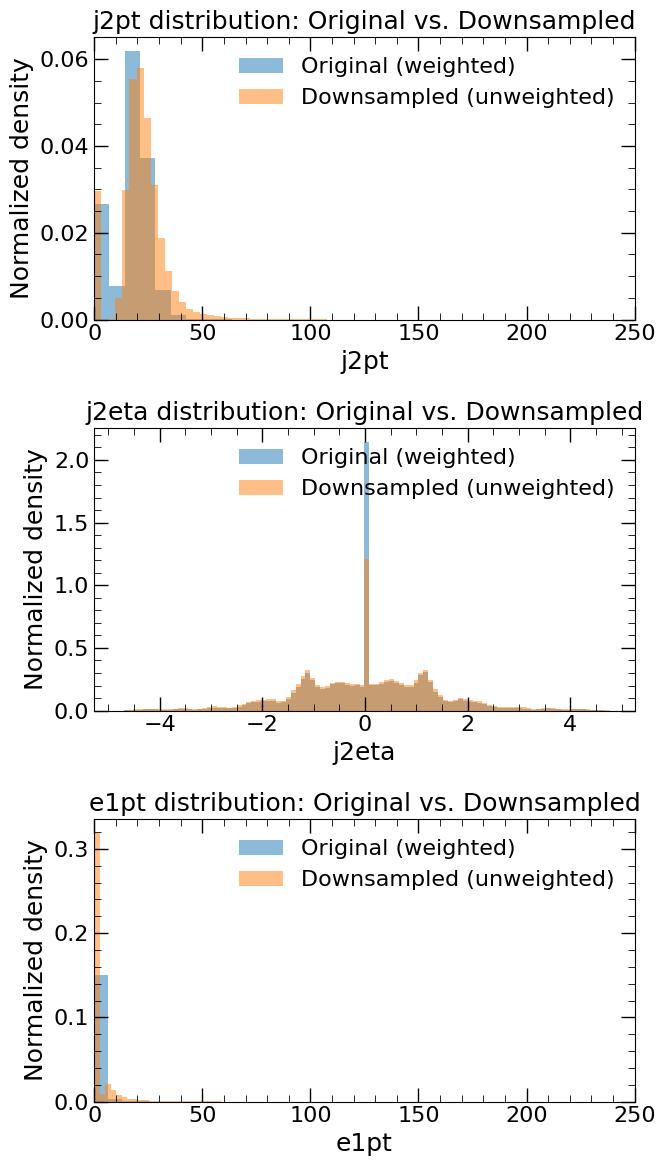

In [18]:
# --- Original and Downsampled Backgrounds ---
mask_bkg = combined_hlt_df['target'] == 'EB_test'
df_bkg = combined_hlt_df.loc[mask_bkg]
weights_bkg = df_bkg['weight']

df_bkg_down = X_major_downsampled.copy()

# --- Variables to plot (you can modify this list) ---
vars_to_plot = ['j2pt', 'j2eta', 'e1pt']

# --- Setup subplot grid ---
n_vars = len(vars_to_plot)
fig, axes = plt.subplots(n_vars, 1, figsize=(7, 4 * n_vars))
if n_vars == 1:
    axes = [axes]  # Ensure axes is iterable even for one plot

# --- Plot each variable ---
for ax, var in zip(axes, vars_to_plot):
    ax.hist(
        df_bkg[var],
        bins=100,
        weights=weights_bkg,
        density=True,
        alpha=0.5,
        label='Original (weighted)',
        histtype='stepfilled'
    )
    ax.hist(
        df_bkg_down[var],
        bins=100,
        density=True,
        alpha=0.5,
        label='Downsampled (unweighted)',
        histtype='stepfilled'
    )
    ax.set_title(f'{var} distribution: Original vs. Downsampled')
    ax.set_xlabel(var)
    ax.set_ylabel('Normalized density')

    # Apply x-axis limits for any variable ending with 'pt'
    if var.endswith('pt'):
        ax.set_xlim(-1, 250)

    ax.legend()

plt.tight_layout()
plt.show()


**Kolmogorov–Smirnov (KS) Test**

#### 📊 What the KS Test Does

The **Kolmogorov–Smirnov (KS) test** compares two samples’ cumulative distribution functions (CDFs) and asks:

> “Are these two samples likely drawn from the same underlying distribution?”

It returns two key values:

- **KS statistic (`D`)** → the *maximum difference* between the two CDFs.  
  - Ranges from **0 to 1**  
  - Smaller values mean **more similar distributions**

- **p-value (`p`)** → the probability that this difference could occur *by chance* if the two distributions were actually the same.  
  - Large p (**> 0.05**) → **can’t reject** the null hypothesis (the distributions look statistically similar)  
  - Small p (**< 0.05**) → **reject** the null hypothesis (the distributions are *significantly different*)


In [19]:
from scipy.stats import ks_2samp

for var in vars_to_plot:
    ks_stat, p_val = ks_2samp(df_bkg[var].sample(10000, random_state=42),
                              df_bkg_down[var])
    print(f'{var}: KS={ks_stat:.3f}, p={p_val:.3f}')


j2pt: KS=0.118, p=0.000
j2eta: KS=0.057, p=0.000
e1pt: KS=0.123, p=0.000


In [20]:
!pip uninstall -y tensorflow tensorflow-gpu

In [21]:
import psutil
print(f"Memory available: {psutil.virtual_memory().available / 1e9:.2f} GB")
print(combined_hlt_df.shape)

Memory available: 6.66 GB
(1487586, 50)


### Random Forest Classifier

In [22]:
# ==== 4) Random Forest (with simple median imputation) ====
rf_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        # class_weight="balanced",   # not needed after manual balancing
        max_features="sqrt"
    ))
])

rf_pipe.fit(X_train, y_train)

# Optional quick sanity check:
train_score = rf_pipe.score(X_train, y_train)
test_score  = rf_pipe.score(X_test,  y_test)
print(f"Accuracy — train: {train_score:.3f}, test: {test_score:.3f}")

# ==== 5) Feature importance ====
# Get the trained RF from the pipeline and pair importances with column names
rf = rf_pipe.named_steps["rf"]
# If you used get_dummies above, use X_train.columns after the transform:
feature_names = X_balanced.columns

importances = pd.DataFrame({
    "feature": feature_names,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False).reset_index(drop=True)

# Show top 10
print(importances.head(5))

Accuracy — train: 1.000, test: 0.927
  feature  importance
0  METphi        0.13
1   METpt        0.12
2    e1pt        0.09
3    j0pt        0.07
4    e2pt        0.06
